In [ ]:
!pip install pyunpack
!pip install patool

     |████████████████████████████████| 81kB 4.0MB/s 


In [ ]:
from pyunpack import Archive

In [ ]:
Archive('/content/drive/My Drive/LSTM/glove.6B.100d.rar').extractall('/content')

In [ ]:
import tensorflow as tf
import os
tf.compat.v1.enable_eager_execution()
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Input, Softmax, RNN, Dense, Embedding, LSTM
from tensorflow.keras.models import Model
import numpy as np
import re
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings('ignore')
import nltk.translate.bleu_score as bleu
from sklearn.model_selection import train_test_split

tf.executing_eagerly()

True

# Data Preparation

In [ ]:
file = open('/content/drive/My Drive/LSTM/ita.txt', 'r', encoding = 'utf8')
text = file.read()
file.close()
file.closed

True

In [ ]:
English = []
Italian = []
i = 0
for line in text.split('\n'):
    #print(line)
    try:
        sent = (line.split('\t')[:2])
        English.append(sent[0])
        Italian.append(sent[1])
    except:
        continue

In [ ]:
del English[-1]
len(English), len(Italian)

(341554, 341554)

In [ ]:
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
    
def preprocess_Eng(text): # Preprocessing of English sentences
    txt = text.lower()
    txt = decontractions(txt)
    txt = re.sub('[^A-Za-z0-9 ]+', '', txt)
    txt = txt.strip()
    return txt

def preprocess_Ita(txt): # Preprocessing of Italian sentences
    text = txt.lower()
    text = decontractions(text)
    text = re.sub('[$)\?"’.°!;\'€%:,(/]', '', text)
    text = re.sub('\u200b', ' ', text)
    text = re.sub('\xa0', ' ', text)
    text = re.sub('-', ' ', text)
    text = text.strip()
    text = '<start> ' + text + ' <eos>' # Appending start and eos tokens at start and end of the italian sentences.
    return text

In [ ]:
# Creating the dataframe of Italian and English sentences
Data = pd.DataFrame(list(zip(Italian, English)), columns = ['Italian', 'English'])
print(Data.head())
len(Data)

    Italian English
0     Ciao!     Hi.
1    Corri!    Run!
2    Corra!    Run!
3  Correte!    Run!
4      Chi?    Who?


341554

In [ ]:
# Preprocessing of sentences.
Data['Italian'] = Data['Italian'].apply(lambda row: preprocess_Ita(row))
Data['English'] = Data['English'].apply(lambda row: preprocess_Eng(row))

Data['Italian_len'] = Data['Italian'].apply(lambda row: len(row.split()) - 2)
Data['Eng_len'] = Data['English'].apply(lambda row: len(row.split()))

In [ ]:
max(Data['Eng_len']), max(Data['Italian_len'])

(101, 92)

In [ ]:
for i in range(0,101,10):
    print(i,np.percentile(Data['Italian_len'], i))
for i in range(90,101):
    print(i,np.percentile(Data['Italian_len'], i))
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(Data['Italian_len'], i))

0 1.0
10 3.0
20 4.0
30 4.0
40 5.0
50 5.0
60 6.0
70 6.0
80 7.0
90 8.0
100 92.0
90 8.0
91 8.0
92 8.0
93 9.0
94 9.0
95 9.0
96 9.0
97 10.0
98 11.0
99 12.0
100 92.0
99.1 12.0
99.2 12.0
99.3 12.0
99.4 13.0
99.5 13.0
99.6 14.0
99.7 15.0
99.8 16.0
99.9 20.0
100 92.0


In [ ]:
for i in range(0,101,10):
    print(i,np.percentile(Data['Eng_len'], i))
for i in range(90,101):
    print(i,np.percentile(Data['Eng_len'], i))
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(Data['Eng_len'], i))

0 1.0
10 4.0
20 4.0
30 5.0
40 5.0
50 6.0
60 6.0
70 7.0
80 7.0
90 8.0
100 101.0
90 8.0
91 9.0
92 9.0
93 9.0
94 9.0
95 9.0
96 10.0
97 10.0
98 11.0
99 12.0
100 101.0
99.1 12.0
99.2 13.0
99.3 13.0
99.4 13.0
99.5 14.0
99.6 14.0
99.7 15.0
99.8 16.0
99.9 20.0
100 101.0




> From the above percentile values, 99 percentile of sentences have length of 20 both in Italian and English sentences. Thus, for this example we are going to use the sentences with the maximum length of 20 words for simplicity.



In [ ]:
# Getting the sentence of maximum length 20
Data = Data[Data['Italian_len'] <= 20]
len(Data)

341248

In [ ]:
# Getting the sentence of maximum length 20
Data = Data[Data['Eng_len'] <= 20]
len(Data)

341207

In [ ]:
# Since teacher forcing method is used, a separate input for decoder as "Decoder_in" and the overall output as "Decoder_out".
# For Decoder_in sentences <start> and <eos> tokens are appended.
# For Decoder_out sentences <eos> token is appended.
Data['Decoder_in'] = Data['English'].apply(lambda row: '<start> ' + row + ' <eos>')
Data['Decoder_out'] = Data['English'].apply(lambda row: row + ' <eos>')

In [ ]:
Data.reset_index(drop=True, inplace = True)
Data.head()

,Italian,English,Italian_len,Eng_len,Decoder_in,Decoder_out
0,<start> ciao <eos>,hi,1,1,<start> hi <eos>,hi <eos>
1,<start> corri <eos>,run,1,1,<start> run <eos>,run <eos>
2,<start> corra <eos>,run,1,1,<start> run <eos>,run <eos>
3,<start> correte <eos>,run,1,1,<start> run <eos>,run <eos>
4,<start> chi <eos>,who,1,1,<start> who <eos>,who <eos>


In [ ]:
Data.sample(10)

,Italian,English,Italian_len,Eng_len,Decoder_in,Decoder_out
214503,<start> tom ha molta paura dei serpenti <eos>,tom is very afraid of snakes,6,6,<start> tom is very afraid of snakes <eos>,tom is very afraid of snakes <eos>
339457,<start> noi potevamo vedere ciò che pensavamo ...,we could see what we thought was a pirate ship...,13,13,<start> we could see what we thought was a pir...,we could see what we thought was a pirate ship...
132962,<start> volevo essere con te <eos>,i wanted to be with you,4,6,<start> i wanted to be with you <eos>,i wanted to be with you <eos>
311669,<start> perché stai indossando una t shirt ros...,why are you wearing a pink tshirt tom,8,8,<start> why are you wearing a pink tshirt tom ...,why are you wearing a pink tshirt tom <eos>
188198,<start> non dovevi dire di sì <eos>,you did not have to say yes,5,7,<start> you did not have to say yes <eos>,you did not have to say yes <eos>
309251,<start> mi voglio sdraiare e riposare per un p...,i want to lie down and rest for a while,8,10,<start> i want to lie down and rest for a whil...,i want to lie down and rest for a while <eos>
117607,<start> dissi a tom che lo odiavo <eos>,i told tom i hated him,6,6,<start> i told tom i hated him <eos>,i told tom i hated him <eos>
25711,<start> odio la mia casa <eos>,i hate my house,4,4,<start> i hate my house <eos>,i hate my house <eos>
247692,<start> non voglio mangiare di nuovo là <eos>,i do not want to eat there again,6,8,<start> i do not want to eat there again <eos>,i do not want to eat there again <eos>
266614,<start> non lo farà qua vero <eos>,you will not do that here will you,5,8,<start> you will not do that here will you <eos>,you will not do that here will you <eos>


In [ ]:
# Splitting the data into train and validation data(Test data).
train, validation = train_test_split(Data, test_size=0.2)
train.reset_index(drop=True, inplace = True)
validation.reset_index(drop=True, inplace = True)
train.shape, validation.shape

((272965, 6), (68242, 6))

In [ ]:
# This function is to create tokenizer for the respctive language sentences.
def Tokenizing(inp):
    Token = Tokenizer(filters = "", oov_token = '<UNK>')
    Token.fit_on_texts(inp)
    
    values = Token.texts_to_sequences(inp)
    values = pad_sequences(values, padding = 'post')
    
    return Token, values

In [ ]:
# English tokenizer on train data.
eng_token, _ = Tokenizing(train['Decoder_in'])
eng_vocab_size = len(eng_token.word_index)
eng_vocab_size

12801

In [ ]:
eng_token.word_index

{'<UNK>': 1,
 '<start>': 2,
 '<eos>': 3,
 'i': 4,
 'you': 5,
 'tom': 6,
 'to': 7,
 'is': 8,
 'not': 9,
 'the': 10,
 'a': 11,
 'do': 12,
 'are': 13,
 'have': 14,
 'it': 15,
 'that': 16,
 'he': 17,
 'was': 18,
 'am': 19,
 'in': 20,
 'we': 21,
 'me': 22,
 'will': 23,
 'did': 24,
 'of': 25,
 'this': 26,
 'be': 27,
 'for': 28,
 'can': 29,
 'what': 30,
 'my': 31,
 'your': 32,
 'want': 33,
 'mary': 34,
 'with': 35,
 'like': 36,
 'why': 37,
 'know': 38,
 'she': 39,
 'go': 40,
 'think': 41,
 'his': 42,
 'here': 43,
 'they': 44,
 'at': 45,
 'would': 46,
 'very': 47,
 'on': 48,
 'and': 49,
 'has': 50,
 'how': 51,
 'there': 52,
 'about': 53,
 'does': 54,
 'now': 55,
 'were': 56,
 'all': 57,
 'going': 58,
 'so': 59,
 'should': 60,
 'get': 61,
 'need': 62,
 'help': 63,
 'as': 64,
 'boston': 65,
 'time': 66,
 'us': 67,
 'him': 68,
 'good': 69,
 'an': 70,
 'had': 71,
 'really': 72,
 'one': 73,
 'tell': 74,
 'who': 75,
 'never': 76,
 'too': 77,
 'still': 78,
 'where': 79,
 'see': 80,
 'come': 81,
 'bee

In [ ]:
# Italian tokenizer on train data.
ita_token, _ = Tokenizing(train['Italian'])
ita_vocab_size = len(ita_token.word_index)
ita_vocab_size

26102

In [ ]:
ita_token.word_index

{'<UNK>': 1,
 '<start>': 2,
 '<eos>': 3,
 'tom': 4,
 'non': 5,
 'è': 6,
 'di': 7,
 'a': 8,
 'che': 9,
 'io': 10,
 'la': 11,
 'il': 12,
 'ha': 13,
 'un': 14,
 'sono': 15,
 'per': 16,
 'in': 17,
 'mi': 18,
 'ho': 19,
 'una': 20,
 'con': 21,
 'lei': 22,
 'mary': 23,
 'perché': 24,
 'molto': 25,
 'le': 26,
 'questo': 27,
 'lo': 28,
 'da': 29,
 'si': 30,
 'i': 31,
 'era': 32,
 'lui': 33,
 'voi': 34,
 'noi': 35,
 'più': 36,
 'cosa': 37,
 'essere': 38,
 'sei': 39,
 'e': 40,
 'me': 41,
 'tu': 42,
 'sta': 43,
 'qui': 44,
 'vero': 45,
 'fare': 46,
 'suo': 47,
 'ci': 48,
 'mai': 49,
 'come': 50,
 'voglio': 51,
 'mio': 52,
 'così': 53,
 'sia': 54,
 'ancora': 55,
 'penso': 56,
 'casa': 57,
 'del': 58,
 'siete': 59,
 'questa': 60,
 'detto': 61,
 'andare': 62,
 'mia': 63,
 'sua': 64,
 'al': 65,
 'hai': 66,
 'fatto': 67,
 'piace': 68,
 'boston': 69,
 'avete': 70,
 'ti': 71,
 'siamo': 72,
 'quello': 73,
 'posso': 74,
 'stato': 75,
 'loro': 76,
 'vi': 77,
 'alla': 78,
 'abbiamo': 79,
 'tutto': 80,
 'tut

In [ ]:
# Ref: https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
# Getting the pre-trained embeddings.
embeddings_index = dict()
f = open('glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [ ]:
# create a weight matrix for words in training english sentences.
embedding_matrix = np.zeros((eng_vocab_size + 1, 100))
for word, i in eng_token.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
# Creating the batch dataset for train and validation.
class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len):
        self.encoder_inps = data['Italian'].values
        self.decoder_inps = data['Decoder_in'].values
        self.decoder_outs = data['Decoder_out'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.max_len = max_len

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [ ]:
# Creating a batch dataset for train and test.
train_dataset = Dataset(train, ita_token, eng_token, 20)
test_dataset  = Dataset(validation, ita_token, eng_token, 20)

train_dataloader = Dataloder(train_dataset, batch_size=1024)
test_dataloader = Dataloder(test_dataset, batch_size=1024)

print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(1024, 20) (1024, 20) (1024, 20)


In [ ]:
test_dataloader[0]

([array([[   2,   34, 1200, ...,    0,    0,    0],
         [   2,   11,  141, ...,    3,    0,    0],
         [   2,   92, 2791, ...,    0,    0,    0],
         ...,
         [   2,    4,   97, ...,    0,    0,    0],
         [   2,   10,   96, ...,    0,    0,    0],
         [   2,   27,    6, ...,    0,    0,    0]], dtype=int32),
  array([[  2,   5, 156, ...,   0,   0,   0],
         [  2,  10, 244, ...,   3,   0,   0],
         [  2,   4,  19, ...,   0,   0,   0],
         ...,
         [  2,   6, 232, ...,   0,   0,   0],
         [  2,   4,  18, ...,   0,   0,   0],
         [  2,  26,   8, ...,   0,   0,   0]], dtype=int32)],
 array([[   5,  156, 3027, ...,    0,    0,    0],
        [  10,  244,  271, ...,    0,    0,    0],
        [   4,   19, 1138, ...,    0,    0,    0],
        ...,
        [   6,  232,   47, ...,    0,    0,    0],
        [   4,   18, 4367, ...,    0,    0,    0],
        [  26,    8,  517, ...,    0,    0,    0]], dtype=int32))

# Simple Encoder-Decoder

In [ ]:
# Encoder Architecture
tf.keras.backend.clear_session()
class Encoder(Model):
    def __init__(self, vocab_size, embed_size, units, input_len):
        super(Encoder, self).__init__()
        self.vocab_size = vocab_size + 1
        self.embed_dim = embed_size
        self.input_length = input_len
        self.lstm_units = units
        self.lstm_output = 0
        self.lstm_state_h = 0
        self.lstm_state_c = 0
        self.embeddings = Embedding(input_dim = self.vocab_size, output_dim = self.embed_dim,
                                  mask_zero=True, input_length = self.input_length, name = 'Encoder_Emb_Layer')
        self.lstm = LSTM(units = self.lstm_units, return_sequences = True,
                        return_state = True, name = 'Encoder_LSTM_Layer')
    
    def call(self, input_sentence, hidden, training = True):
        #print('Encoder === I/p shape before Embedding : ', input_sentence.shape)
        input_emb = self.embeddings(input_sentence)
        #print('Encoder === I/p shape after Embedding : ', input_emb.shape)
        self.lstm_output, self.lstm_state_h, self.lstm_state_c = self.lstm(input_emb, initial_state = hidden)
        return self.lstm_output, self.lstm_state_h, self.lstm_state_c
    
    def get_states(self):
        return self.lstm_state_h, self.lstm_state_c
    
    def initialize_states(self,batch_size):
        self.lstm_state_h = tf.zeros((batch_size, self.lstm_units))
        self.lstm_state_c = tf.zeros((batch_size, self.lstm_units))
        return [self.lstm_state_h, self.lstm_state_c ]

In [ ]:
# Decoder Architecture
class Decoder(Model):
    def __init__(self, vocab_size, embed_size, units, output_len, emb_matrix):
        super(Decoder, self).__init__()
        self.vocab_size = vocab_size + 1
        self.embed_dim = embed_size
        self.output_length = output_len
        self.lstm_units = units
        self.matrix = emb_matrix

        self.embeddings = Embedding(input_dim = self.vocab_size, output_dim = self.embed_dim,
                                  mask_zero=True, input_length = self.output_length, weights=[self.matrix], trainable=False,
                                    name = 'Decoder_Emb_Layer') # Using pre-trained embedding matrix obtained from glove.
        self.lstm = LSTM(units = self.lstm_units, return_sequences = True,
                        return_state = True, name = 'Decoder_LSTM_Layer')
    
    def call(self, output_sentences, state):
        #print('Decoder === I/p shape before Embedding : ', output_sentences.shape)
        output_emb = self.embeddings(output_sentences)
        #print('Decoder === I/p shape after Embedding : ', output_emb.shape)
        lstm_output, decoder_h, decoder_c = self.lstm(output_emb, initial_state = state)
        return lstm_output, decoder_h, decoder_c
    

In [ ]:
# Creating the overall model architecture
class ED(Model):
    def __init__(self, ip_vocab_size, ip_embed_size, input_len, units, op_vocab_size, op_embed_size, output_len, batch_size, emb_matrix):
        super(ED, self).__init__() 
        self.batch_size = batch_size
        self.encoder = Encoder(vocab_size = ip_vocab_size, embed_size = ip_embed_size, 
                                units = units, input_len = input_len)
        self.decoder = Decoder(vocab_size = op_vocab_size, embed_size = op_embed_size, 
                                units = units, output_len = output_len, emb_matrix = emb_matrix)
        self.dense = Dense(units = op_vocab_size, activation = 'softmax')
    
    def call(self, data):
        initial_state = self.encoder.initialize_states(self.batch_size)
        lang1, lang2 = data[0], data[1]
        #print("="*20, "ENCODER", "="*20)
        encoder_output, encoder_h, encoder_c = self.encoder(lang1, initial_state) # Encoder
        #print("-"*27)
        #print("ENCODER ==> OUTPUT SHAPE",encoder_output.shape)
        #print("ENCODER ==> HIDDEN STATE SHAPE",encoder_h.shape)
        #print("ENCODER ==> CELL STATE SHAPE", encoder_c.shape)
        #print("="*20, "DECODER", "="*20)
        decoder_output, decoder_h, decoder_c  = self.decoder(lang2, [encoder_h, encoder_c]) # Decoder
        output = self.dense(decoder_output) # Dense
        #print("-"*27)
        #print("FINAL OUTPUT SHAPE",output.shape)
        #print("="*50)
        return output

In [ ]:
tf.keras.backend.clear_session()
model1  = ED(ip_vocab_size = ita_vocab_size, ip_embed_size = 100, 
                 input_len = 20, units = 64, op_vocab_size = eng_vocab_size, op_embed_size = 100, output_len = 20,
              batch_size = 1024, emb_matrix = embedding_matrix)

In [ ]:
# Loss Function
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
optimizer = tf.keras.optimizers.Adam()

model1.compile(optimizer = optimizer,loss = [loss_function])

train_steps = train.shape[0]//1024
valid_steps = validation.shape[0]//1024
model1.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=50, validation_data=test_dataloader, validation_steps=valid_steps)
model1.summary()

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
266/266 [==============================] - 227s 854ms/step - loss: 0.7958 - val_loss: 0.7102
Epoch 2/50
266/266 [==============================] - 221s 832ms/step - loss: 0.6983 - val_loss: 0.6802
Epoch 3/50
266/266 [==============================] - 222s 834ms/step - loss: 0.6662 - val_loss: 0.6460
Epoch 4/50
266/266 [==============================] - 225s 846ms/step - loss: 0.6224 - val_loss: 0.5957
Epoch 5/50
266/266 [==============================] - 228s 858ms/step - loss: 0.5705 - val_loss: 0.5452
Epoch 6/50
266/266 [==============================] - 224s 841ms/step - loss: 0.5258 - val_loss: 0.5076
Epoch 7/50
266/266 [==============================] - 224s 842ms/step - loss: 0.4895 - val_loss: 0.4741
Epoch 8/50
266/266 [==============================] - 229s 859ms/step - loss: 0.4577 - val_loss: 0.4465
Epoch 9/50
266/266 [==============================] - 226s 849ms/step - loss: 0.4313 - val_l

In [ ]:
def Translator(ita, eng_ref):
  print("=" * 30, "Inference", "=" * 30)
  test = ita_token.texts_to_sequences([ita])
  test = pad_sequences([test[0]], maxlen=20, dtype='int32', padding='post')
  test = tf.convert_to_tensor(test)
  initial_state = model1.layers[0].initialize_states(1)
  enc_output, enc_state_h, enc_state_c = model1.layers[0](test, initial_state)
  states_values = [enc_state_h, enc_state_c]
  pred = []
  cur_vec = tf.expand_dims([eng_token.word_index['<start>']], 0)
  print('-'*20,"started predition","-"*20)
  print("at time step 0 the word is 0")
  for i in range(20):
      infe_output, state_h, state_c = model1.layers[1](cur_vec, states_values)
      infe_output=model1.layers[2](infe_output)
      states_values = [state_h, state_c]
      # np.argmax(infe_output) will be a single value, which represents the the index of predicted word
      # but to pass this data into next time step embedding layer, we are reshaping it into (1,1) shape
      cur_vec1 = np.argmax(infe_output)
      cur_vec = np.reshape(np.argmax(infe_output), (1, 1))
      print("at time step", i, "the word is ", cur_vec)
      pred.append(cur_vec1)
      if cur_vec == 3: # To terminate loop when <eos> occurs.
        break

  print() 
  print('Italian: ', ita)
  print('Eng_ref: ', eng_ref)
  result = ''
  for i in pred:
    if i != 0:
      result += eng_token.index_word[i] + ' '
  print('Predicted: ', result)
  reference = [eng_ref.split()] # the original
  translation = result.split() # translated using model
  print()
  print('BLEU score: {}'.format(bleu.sentence_bleu(reference, translation[:-1]))) # Bleu score claculation





> Sample Outputs



In [ ]:
num = 64302
Ita = validation['Italian'][num]
Eng = validation['English'][num]
Translator(Ita, Eng)

============================== Inference ==============================
-------------------- started predition --------------------
at time step 0 the word is 0
at time step 0 the word is  [[5]]
at time step 1 the word is  [[13]]
at time step 2 the word is  [[47]]
at time step 3 the word is  [[666]]
at time step 4 the word is  [[3]]

Italian:  <start> voi siete molto curiosi <eos>
Eng_ref:  you are very curious
Predicted:  you are very curious <eos> 

BLEU score: 1.0


In [ ]:
num = 1564
Ita = validation['Italian'][num]
Eng = validation['English'][num]
Translator(Ita, Eng)

============================== Inference ==============================
-------------------- started predition --------------------
at time step 0 the word is 0
at time step 0 the word is  [[100]]
at time step 1 the word is  [[22]]
at time step 2 the word is  [[26]]
at time step 3 the word is  [[1888]]
at time step 4 the word is  [[3]]

Italian:  <start> tutti utilizzano google <eos>
Eng_ref:  everyone uses google
Predicted:  let me this opportunity <eos> 

BLEU score: 0


In [ ]:
num = 100
Ita = validation['Italian'][num]
Eng = validation['English'][num]
Translator(Ita, Eng)

============================== Inference ==============================
-------------------- started predition --------------------
at time step 0 the word is 0
at time step 0 the word is  [[218]]
at time step 1 the word is  [[6]]
at time step 2 the word is  [[49]]
at time step 3 the word is  [[34]]
at time step 4 the word is  [[13]]
at time step 5 the word is  [[47]]
at time step 6 the word is  [[354]]
at time step 7 the word is  [[3]]

Italian:  <start> sia tom che mary hanno molta fame <eos>
Eng_ref:  tom and mary are both very hungry
Predicted:  both tom and mary are very hungry <eos> 

BLEU score: 0.5081327481546147


In [ ]:
num = 18984
Ita = validation['Italian'][num]
Eng = validation['English'][num]
Translator(Ita, Eng)

============================== Inference ==============================
-------------------- started predition --------------------
at time step 0 the word is 0
at time step 0 the word is  [[100]]
at time step 1 the word is  [[8]]
at time step 2 the word is  [[40]]
at time step 3 the word is  [[109]]
at time step 4 the word is  [[3]]

Italian:  <start> ritorniamo <eos>
Eng_ref:  let is turn back
Predicted:  let is go back <eos> 

BLEU score: 0.7071067811865475


In [ ]:
num = 30000
Ita = validation['Italian'][num]
Eng = validation['English'][num]
Translator(Ita, Eng)

============================== Inference ==============================
-------------------- started predition --------------------
at time step 0 the word is 0
at time step 0 the word is  [[14]]
at time step 1 the word is  [[10]]
at time step 2 the word is  [[1228]]
at time step 3 the word is  [[20]]
at time step 4 the word is  [[148]]
at time step 5 the word is  [[478]]
at time step 6 the word is  [[3]]

Italian:  <start> fervono i preparativi per la cerimonia <eos>
Eng_ref:  preparations for the ceremony are under way
Predicted:  have the interest in our country <eos> 

BLEU score: 0.5408536609893481


In [ ]:
num = 61
Ita = validation['Italian'][num]
Eng = validation['English'][num]
Translator(Ita, Eng)

============================== Inference ==============================
-------------------- started predition --------------------
at time step 0 the word is 0
at time step 0 the word is  [[15]]
at time step 1 the word is  [[8]]
at time step 2 the word is  [[352]]
at time step 3 the word is  [[7092]]
at time step 4 the word is  [[115]]
at time step 5 the word is  [[128]]
at time step 6 the word is  [[3]]

Italian:  <start> fa più caldo giorno dopo giorno <eos>
Eng_ref:  it is getting warmer day by day
Predicted:  it is getting hotter than day <eos> 

BLEU score: 0.43012508513132625


In [ ]:
num = 18
Ita = validation['Italian'][num]
Eng = validation['English'][num]
Translator(Ita, Eng)

============================== Inference ==============================
-------------------- started predition --------------------
at time step 0 the word is 0
at time step 0 the word is  [[31]]
at time step 1 the word is  [[348]]
at time step 2 the word is  [[18]]
at time step 3 the word is  [[31]]
at time step 4 the word is  [[781]]
at time step 5 the word is  [[2020]]
at time step 6 the word is  [[3]]

Italian:  <start> la mia macchina fotografica è stata rubata sul treno <eos>
Eng_ref:  my camera was stolen on the train
Predicted:  my train was my camera repaired <eos> 

BLEU score: 0.5115078115793242


In [ ]:
num = 60000
Ita = validation['Italian'][num]
Eng = validation['English'][num]
Translator(Ita, Eng)

============================== Inference ==============================
-------------------- started predition --------------------
at time step 0 the word is 0
at time step 0 the word is  [[6]]
at time step 1 the word is  [[446]]
at time step 2 the word is  [[11]]
at time step 3 the word is  [[709]]
at time step 4 the word is  [[3]]

Italian:  <start> tom cambiò colore <eos>
Eng_ref:  tom changed color
Predicted:  tom changed a knife <eos> 

BLEU score: 0.6389431042462724


In [ ]:
num = 891
Ita = validation['Italian'][num]
Eng = validation['English'][num]
Translator(Ita, Eng)

============================== Inference ==============================
-------------------- started predition --------------------
at time step 0 the word is 0
at time step 0 the word is  [[15]]
at time step 1 the word is  [[8]]
at time step 2 the word is  [[549]]
at time step 3 the word is  [[3]]

Italian:  <start> è strano <eos>
Eng_ref:  it is odd
Predicted:  it is strange <eos> 

BLEU score: 0.7598356856515925


In [ ]:
# Calculating bleu scores for first 100 val data.
REF = []
PRED = []
BLEU = []
for i in range(1,101):
  Ita = validation['Italian'][i]
  Eng = validation['English'][i]
  test = ita_token.texts_to_sequences([Ita])
  test = pad_sequences([test[0]], maxlen=20, dtype='int32', padding='post')
  test = tf.convert_to_tensor(test)
  initial_state = model1.layers[0].initialize_states(1)
  enc_output, enc_state_h, enc_state_c = model1.layers[0](test, initial_state)
  states_values = [enc_state_h, enc_state_c]
  pred = []
  cur_vec = tf.expand_dims([eng_token.word_index['<start>']], 0)
  for i in range(20):
      infe_output, state_h, state_c = model1.layers[1](cur_vec, states_values)
      infe_output=model1.layers[2](infe_output)
      states_values = [state_h, state_c]
      # np.argmax(infe_output) will be a single value, which represents the the index of predicted word
      # but to pass this data into next time step embedding layer, we are reshaping it into (1,1) shape
      cur_vec1 = np.argmax(infe_output)
      cur_vec = np.reshape(np.argmax(infe_output), (1, 1))
      pred.append(cur_vec1)
      if cur_vec == 3:
        break

  result = ''
  for i in pred:
    if i != 0:
      result += eng_token.index_word[i] + ' '
  reference = [Eng.split()] # the original
  translation = result.split() # translated using model

  b = bleu.sentence_bleu(reference, translation[:-1])
  REF.append(Eng)
  PRED.append(result)
  BLEU.append(b)

In [ ]:
OUTPUT = pd.DataFrame(list(zip(REF, PRED, BLEU)), columns = ['Reference', 'Predicited', 'BLEU_Score'])
OUTPUT.head(10)

,Reference,Predicited,BLEU_Score
0,the first thing tom does every day when he get...,the doctor what time will you spend when to go...,0.367481
1,i am beginning to agree with you,i am beginning to agree with you <eos>,1.000000
2,i feel really lucky right now,i feel really lucky right now <eos>,1.000000
3,the boy you killed was your son,the boy admitted that boy was a doctor <eos>,0.481098
4,he changed a few words,he changed a change of the refrigerator <eos>,0.411134
5,i did not catch their names,i have not understood their names <eos>,0.604275
6,this is the lady i spoke of yesterday,this was the first person i did not hand <eos>,0.759836
7,would you like to stay for lunch,would you like to stay at christmas <eos>,0.614788
8,i know that tom is alone,i know tom is alone <eos>,0.578930
9,i hate to see children cry,i hate children in the bed <eos>,0.562341


In [ ]:
print("Average bleu score on 100 validation data: {:.4f}".format(np.mean(BLEU)))

Average bleu score on 100 validation data: 0.6605


# Encoder-Decoder with Attention Architecture

In [ ]:
# Encoder Architecture
tf.keras.backend.clear_session()
class Encoder(Model):
    def __init__(self, vocab_size, embed_size, units, input_len):
        super(Encoder, self).__init__()
        self.vocab_size = vocab_size + 1
        self.embed_dim = embed_size
        self.input_length = input_len
        self.lstm_units = units
        self.lstm_output = 0
        self.lstm_state_h = 0
        self.lstm_state_c = 0
        self.embeddings = Embedding(input_dim = self.vocab_size, output_dim = self.embed_dim,
                                    input_length = self.input_length, name = 'Encoder_Emb_Layer')
        self.lstm = LSTM(units = self.lstm_units, return_sequences = True,
                        return_state = True, name = 'Encoder_LSTM_Layer')
    
    def call(self, input_sentence, hidden, training = True):
        #print('Encoder === I/p shape before Embedding : ', input_sentence.shape)
        input_emb = self.embeddings(input_sentence)
        #print('Encoder === I/p shape after Embedding : ', input_emb.shape)
        self.lstm_output, self.lstm_state_h, self.lstm_state_c = self.lstm(input_emb, initial_state = hidden)
        return self.lstm_output, self.lstm_state_h, self.lstm_state_c
    
    def get_states(self):
        return self.lstm_state_h, self.lstm_state_c
    
    def initialize_states(self,batch_size):
        self.lstm_state_h = tf.zeros((batch_size, self.lstm_units))
        self.lstm_state_c = tf.zeros((batch_size, self.lstm_units))
        return [self.lstm_state_h, self.lstm_state_c] 

In [ ]:
# BahdanauAttention
# Ref: https://arxiv.org/pdf/1508.04025.pdf
'''
      Attention mechanism takes two inputs current step -- decoder_hidden_state and all the encoder_outputs.
      * Based on the scoring function we will find the score or similarity between decoder_hidden_state and encoder_output.
        Multiply the score function with your encoder_outputs to get the context vector.
        Function returns context vector and attention weights(softmax - scores)
    '''
class Attention(tf.keras.layers.Layer):
    def __init__(self, att_func, att_units):
        super(Attention, self).__init__()
        self.units = att_units
        self.func = att_func
    
    def build(self, input_shape):
        if(self.func == 'general'):
            self.Wa = self.add_weight(shape=(input_shape[-1], self.units), initializer='glorot_uniform',
                               trainable=True)
        if(self.func == 'concat'):
            self.W1 = self.add_weight(shape=(input_shape[-1], self.units), initializer='glorot_uniform',
                               trainable=True)
            self.W2 = self.add_weight(shape=(input_shape[-1], self.units), initializer='glorot_uniform',
                               trainable=True)
            self.va = self.add_weight(shape=(input_shape[-1], 1), initializer='glorot_uniform',
                               trainable=True)
            #print('W1 shape', self.W1.shape, 'va shape', self.va.shape)
    
    def call(self, decoder_hidden_state, encoder_output):
        query = tf.expand_dims(decoder_hidden_state, axis = 1)
        #print('Query shape', query.shape, 'Values shape', encoder_output.shape)
        # query: (batch_size, 1, rnn_units)
        # encoder_output a.k.a values: (batch_size, max_len, rnn_units)

        # Three ways of calculating attention weights
        if self.func == 'dot':
            scores = tf.matmul(encoder_output, query, transpose_b = True)
        
        if self.func == 'general':
            temp = tf.matmul(encoder_output, self.Wa, transpose_b = True)
            scores = tf.matmul(temp, query, transpose_b = True)
            
        if self.func == 'concat':
            temp = tf.matmul(query, self.W1, transpose_b = True) + tf.matmul(encoder_output, self.W2, transpose_b = True)
            temp = tf.nn.tanh(temp)
            scores = tf.matmul(temp, self.va)
        
        
        attention_weights = tf.nn.softmax(scores, axis = 1)
        
        context_vector = attention_weights * encoder_output
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights
            
            

In [ ]:
class One_Step_Decoder(tf.keras.Model):
    def __init__(self, tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units, embedding_matrix):
        super(One_Step_Decoder, self).__init__()
        # Initialize decoder embedding layer, LSTM and any other objects needed
        self.embedding = Embedding(input_dim = tar_vocab_size + 1, output_dim = embedding_dim, mask_zero=True,
                                   input_length = input_length, weights=[embedding_matrix], trainable=False)
        self.attention = Attention(score_fun, att_units)
        self.lstm = LSTM(units = dec_units, return_sequences = True,
                        return_state = True)
        self.dense = Dense(units = tar_vocab_size, activation = 'softmax')
        

    def call(self, input_to_decoder, encoder_output, state_h, state_c):
        '''
        One step decoder mechanisim step by step:
      A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
      B. Using the encoder_output and decoder hidden state, compute the context vector.
      C. Concat the context vector with the step A output
      D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
      E. Pass the decoder output to dense layer(vocab size) and store the result into output.
      F. Return the states from step D, output from Step E, attention weights from Step -B
        '''
        # A
        #print('Decoder === I/p shape before Embedding : ', input_to_decoder.shape)
        embedded = self.embedding(input_to_decoder)
        #print('Emb', embedded.shape)
        #print('Decoder === I/p shape after Embedding : ', embedded.shape)
        
        # B
        context_vector, attention_weights = self.attention(state_h, encoder_output)
        temp = tf.expand_dims(context_vector, axis = 1)
        #print('Cont', context_vector.shape, 'Att_w', attention_weights.shape)
        
        # C
        temp = tf.concat([embedded, temp], axis=-1)
        #print('Concat', temp.shape)
        
        # D
        decoded_op, decoded_h, decoded_c = self.lstm(temp)
        #print('dec_out', decoded_op.shape, 'h', decoded_h.shape, 'c', decoded_c.shape)
        decoded_op = tf.squeeze(decoded_op, axis = 1)
        #decoded_op = tf.reshape(decoded_op, (-1, decoded_op.shape[2]))
        #print('dec_out', decoded_op.shape)
        
        # E
        output = self.dense(decoded_op)
        #print('Out', output.shape)
        
        # F
        return output, decoded_h, decoded_c, attention_weights, context_vector
        
        


In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units, emb_matrix):
      #Intialize necessary variables and create an object from the class onestepdecoder
        super(Decoder, self).__init__()
        self.onestepdecoder = One_Step_Decoder(out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units, emb_matrix)
        self.max_len = input_length
    def call(self, input_to_decoder, encoder_output, decoder_h, decoder_c):

        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        #Create a tensor array as shown in the reference notebook
        
        #Iterate till the length of the decoder input
            # Call onestepdecoder for each token in decoder_input
            # Store the output in tensorarray
        # Return the tensor array
        #print(input_to_decoder.shape)
        Output = tf.TensorArray(tf.float32, size = self.max_len)
        
        for step in range(self.max_len):
            
            output, decoder_h, decoder_c, att_weights, _ = self.onestepdecoder(input_to_decoder[:, step:step+1], encoder_output, 
                                                              decoder_h, decoder_c)
            
            Output = Output.write(step, output)
            
        Output = tf.transpose(Output.stack(), [1, 0, 2])
        #print('Final_Out', Output.shape)
        
        return Output, att_weights              

In [ ]:
# Creating the overall model architecture
class Encoder_Decoder(Model):
    def __init__(self, ip_vocab_size, ip_embed_size, input_len, units, op_vocab_size, op_embed_size, output_len, score_func, batch_size, emb_matrix):
        super(Encoder_Decoder, self).__init__() 
        self.batch_size = batch_size
        self.encoder = Encoder(ip_vocab_size, ip_embed_size, units, input_len)
        self.decoder = Decoder(op_vocab_size, op_embed_size, output_len, units ,score_func, 
                               units, emb_matrix)
        #self.dense = Dense(units = op_vocab_size, activation = 'softmax')
    
    def call(self, data):
        initial_state = self.encoder.initialize_states(self.batch_size)
        lang1, lang2 = data[0], data[1]
        #print("="*20, "ENCODER", "="*20)
        encoder_output, encoder_h, encoder_c = self.encoder(lang1, initial_state) # Encoder
        #print("-"*27)
        #print("ENCODER ==> OUTPUT SHAPE",encoder_output.shape)
        #print("ENCODER ==> HIDDEN STATE SHAPE",encoder_h.shape)
        #print("ENCODER ==> CELL STATE SHAPE", encoder_c.shape)
        #print("="*20, "DECODER", "="*20)
        decoder_output, _  = self.decoder(lang2, encoder_output, encoder_h, encoder_c) # Decoder
        #op = tf.reshape(decoder_output, (-1, decoder_output.shape[2]))
        #output = self.dense(op)
        #print("-"*27)
        #print("FINAL OUTPUT SHAPE",decoder_output.shape)
        #print("="*50)
        return decoder_output

In [ ]:
# Ref: https://www.tensorflow.org/tutorials/text/nmt_with_attention
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none')

def loss_function(y_true, y_pred):
  mask = tf.math.logical_not(tf.math.equal(y_true, 0))
  loss_ = loss_object(y_true, y_pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

# Prediction

> Custom functions for prediction, displaying the context and plotting of attention weights.



In [ ]:
def predict(text, md):
  print("=" * 30, "Inference", "=" * 30)
  test = ita_token.texts_to_sequences([text])
  test = pad_sequences([test[0]], maxlen=20, dtype='int32', padding='post')
  test = tf.convert_to_tensor(test)
  initial_state = md.layers[0].initialize_states(1)
  enc_output, enc_state_h, enc_state_c = md.layers[0](test, initial_state)
  state_h, state_c = enc_state_h, enc_state_c
  pred = []
  cur_vec = tf.expand_dims([eng_token.word_index['<start>']], 0)
  print('-'*20,"started predition","-"*20)
  print("at time step 0 the word is 0")
  ATT = np.zeros((20, 20))
  for i in range(20):
      infe_output, state_h, state_c, att_weights, _ = md.layers[1].onestepdecoder(cur_vec, enc_output, state_h, state_c)
      # np.argmax(infe_output) will be a single value, which represents the the index of predicted word
      # but to pass this data into next time step embedding layer, we are reshaping it into (1,1) shape
      att_weights = tf.reshape(att_weights, (-1, ))
      cur_vec1 = np.argmax(infe_output)
      cur_vec = np.reshape(np.argmax(infe_output), (1, 1))
      ATT[i] = att_weights.numpy()
      print("at time step", i, "the word is ", cur_vec)
      pred.append(cur_vec1)
      if cur_vec1 == 3:
        break
  return pred, ATT

In [ ]:
def display(ita, eng_ref, pred):
  print('Italian: ', ita)
  print('Eng_ref: ', eng_ref)
  result = ''
  for i in pred:
    if i != 0:
      result += eng_token.index_word[i] + ' '
  print('Predicted: ', result)
  reference = [eng_ref.split()] # the original
  translation = result.split() # translated using model
  print()
  print('BLEU score: {}'.format(bleu.sentence_bleu(reference, translation[:-1])))
  return result

In [ ]:
def plot(att, ita, pred):
  attention_plot = att[:len(pred.split(' ')), :len(ita.split(' '))]
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention_plot, cmap = 'viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + ita.split(), fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + pred.split(), fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

# Concat

> Using Concat function



In [ ]:
tf.keras.backend.clear_session()
model  = Encoder_Decoder(ip_vocab_size = ita_vocab_size, ip_embed_size = 100, 
                 input_len = 20, units = 64, op_vocab_size = eng_vocab_size, op_embed_size = 100, output_len = 20, 
                 score_func = 'concat', batch_size = 1024, emb_matrix = embedding_matrix)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer = optimizer,loss = [loss_function])

train_steps = train.shape[0]//1024
valid_steps = validation.shape[0]//1024
model.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=50, validation_data=test_dataloader, validation_steps=valid_steps)
model.summary()

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
266/266 [==============================] - 119s 446ms/step - loss: 2.0781 - val_loss: 1.8531
Epoch 2/50
266/266 [==============================] - 117s 438ms/step - loss: 1.8406 - val_loss: 1.8233
Epoch 3/50
266/266 [==============================] - 120s 450ms/step - loss: 1.7897 - val_loss: 1.7369
Epoch 4/50
266/266 [==============================] - 116s 438ms/step - loss: 1.6886 - val_loss: 1.6316
Epoch 5/50
266/266 [==============================] - 119s 448ms/step - loss: 1.5572 - val_loss: 1.4800
Epoch 6/50
266/266 [==============================] - 117s 439ms/step - loss: 1.4197 - val_loss: 1.3633
Epoch 7/50
266/266 [==============================] - 119s 449ms/step - loss: 1.3021 - val_loss: 1.2522
Epoch 8/50
266/266 [==============================] - 117s 440ms/step - loss: 1.1982 - val_loss: 1.1587
Epoch 9/50
266/266 [==============================] - 120s 450ms/step - loss: 1.1029 - val_l

In [ ]:
validation.sample(10)

,Italian,English,Italian_len,Eng_len,Decoder_in,Decoder_out
8943,<start> non ho tempo <eos>,i am out of time,3,5,<start> i am out of time <eos>,i am out of time <eos>
36236,<start> io non devo indossare una cravatta dov...,i do not need to wear a tie where i work,8,11,<start> i do not need to wear a tie where i wo...,i do not need to wear a tie where i work <eos>
4718,<start> sarà la benvenuta in qualsiasi momento...,you will be welcome at any time,6,7,<start> you will be welcome at any time <eos>,you will be welcome at any time <eos>
67813,<start> sono veramente obesi <eos>,they are really obese,3,4,<start> they are really obese <eos>,they are really obese <eos>
20109,<start> tom era alticcio <eos>,tom was tipsy,3,3,<start> tom was tipsy <eos>,tom was tipsy <eos>
33950,<start> fai attenzione tom <eos>,be careful tom,3,3,<start> be careful tom <eos>,be careful tom <eos>
15566,<start> tom era vestito di blu <eos>,tom was dressed in blue,5,5,<start> tom was dressed in blue <eos>,tom was dressed in blue <eos>
32446,<start> pioverà per tutto il fine settimana <eos>,it is going to rain all weekend,6,7,<start> it is going to rain all weekend <eos>,it is going to rain all weekend <eos>
60272,<start> non correrò <eos>,i will not run,2,4,<start> i will not run <eos>,i will not run <eos>
33492,<start> lei è insistente <eos>,you are persistent,3,3,<start> you are persistent <eos>,you are persistent <eos>


Sample Outputs

In [ ]:
num = 23713
Ita = validation['Italian'][num]
Eng = validation['English'][num]

============================== Inference ==============================
-------------------- started predition --------------------
at time step 0 the word is 0
at time step 0 the word is  [[148]]
at time step 1 the word is  [[1469]]
at time step 2 the word is  [[3]]

Italian:  <start> tutto cambia <eos>
Eng_ref:  everything changes
Predicted:  everything changes <eos> 

BLEU score: 1.0



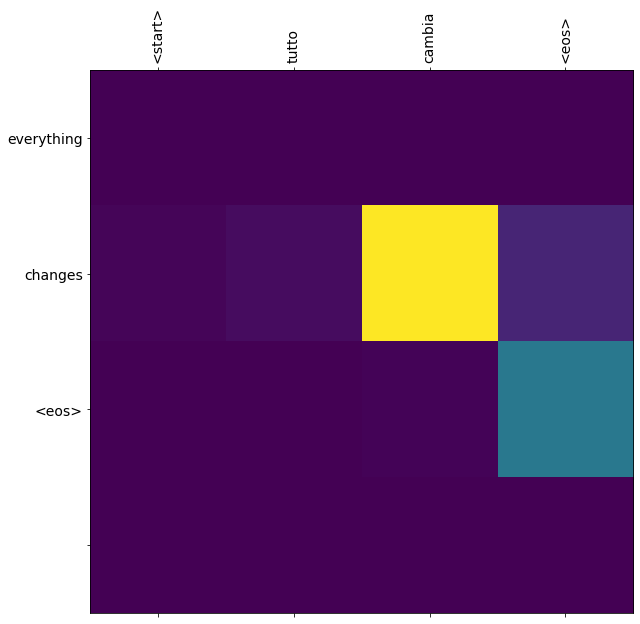

In [ ]:
pred, att = predict(Ita, model)
print()
result = display(Ita, Eng, pred)
print()
plot(att, Ita, result)

In [ ]:
num = 10000
Ita = validation['Italian'][num]
Eng = validation['English'][num]

============================== Inference ==============================
-------------------- started predition --------------------
at time step 0 the word is 0
at time step 0 the word is  [[362]]
at time step 1 the word is  [[50]]
at time step 2 the word is  [[2688]]
at time step 3 the word is  [[663]]
at time step 4 the word is  [[3]]

Italian:  <start> nessuno ha preso peso <eos>
Eng_ref:  nobody gained weight
Predicted:  nobody has gained weight <eos> 

BLEU score: 0.7071067811865475



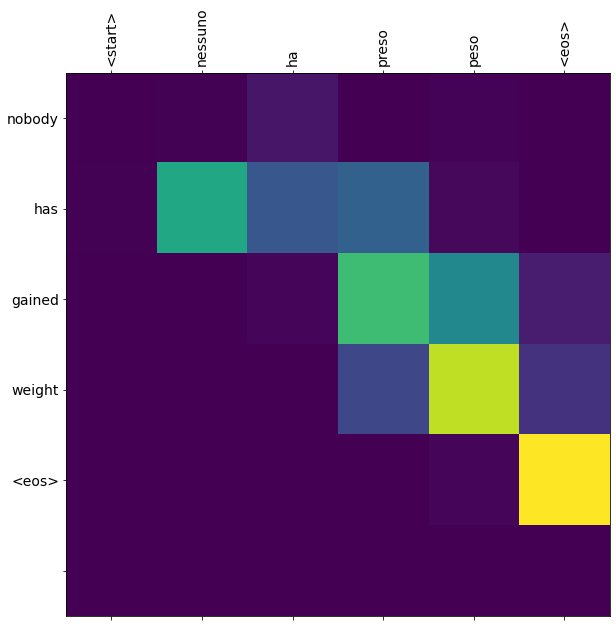

In [ ]:
pred, att = predict(Ita, model)
print()
result = display(Ita, Eng, pred)
print()
plot(att, Ita, result)

In [ ]:
num = 256
Ita = validation['Italian'][num]
Eng = validation['English'][num]

============================== Inference ==============================
-------------------- started predition --------------------
at time step 0 the word is 0
at time step 0 the word is  [[10]]
at time step 1 the word is  [[619]]
at time step 2 the word is  [[50]]
at time step 3 the word is  [[244]]
at time step 4 the word is  [[3]]

Italian:  <start> finalmente è capitato <eos>
Eng_ref:  it finally happened
Predicted:  the weather has happened <eos> 

BLEU score: 0.7071067811865476



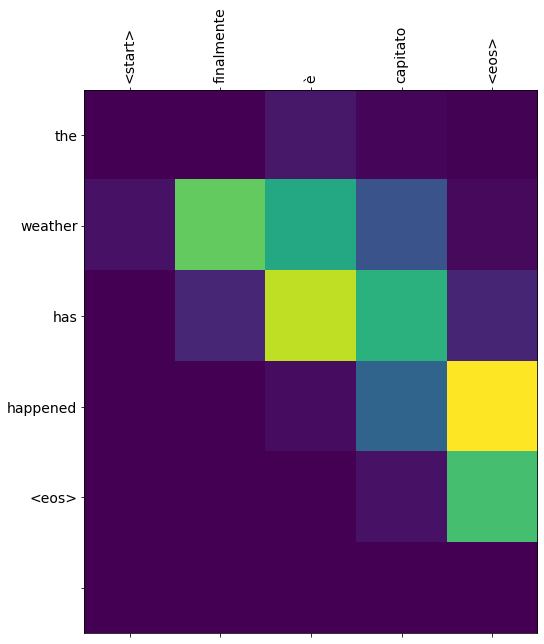

In [ ]:
pred, att = predict(Ita, model)
print()
result = display(Ita, Eng, pred)
print()
plot(att, Ita, result)

In [ ]:
num = 1454
Ita = validation['Italian'][num]
Eng = validation['English'][num]

============================== Inference ==============================
-------------------- started predition --------------------
at time step 0 the word is 0
at time step 0 the word is  [[417]]
at time step 1 the word is  [[6]]
at time step 2 the word is  [[23]]
at time step 3 the word is  [[9]]
at time step 4 the word is  [[325]]
at time step 5 the word is  [[3]]

Italian:  <start> forse tom non vincerà <eos>
Eng_ref:  maybe tom will not win
Predicted:  maybe tom will not win <eos> 

BLEU score: 1.0



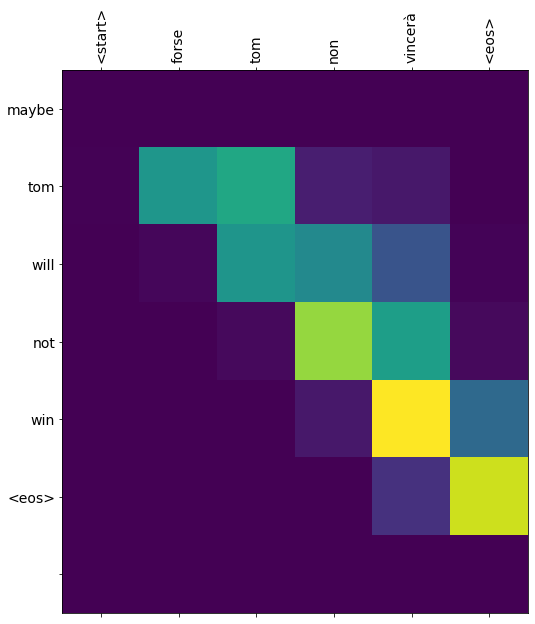

In [ ]:
pred, att = predict(Ita, model)
print()
result = display(Ita, Eng, pred)
print()
plot(att, Ita, result)

In [ ]:
num = 100
Ita = validation['Italian'][num]
Eng = validation['English'][num]

============================== Inference ==============================
-------------------- started predition --------------------
at time step 0 the word is 0
at time step 0 the word is  [[4]]
at time step 1 the word is  [[843]]
at time step 2 the word is  [[843]]
at time step 3 the word is  [[12]]
at time step 4 the word is  [[2175]]
at time step 5 the word is  [[3]]

Italian:  <start> io suono anche il trombone <eos>
Eng_ref:  i also play the trombone
Predicted:  i also also a trombone <eos> 

BLEU score: 0.6223329772884784



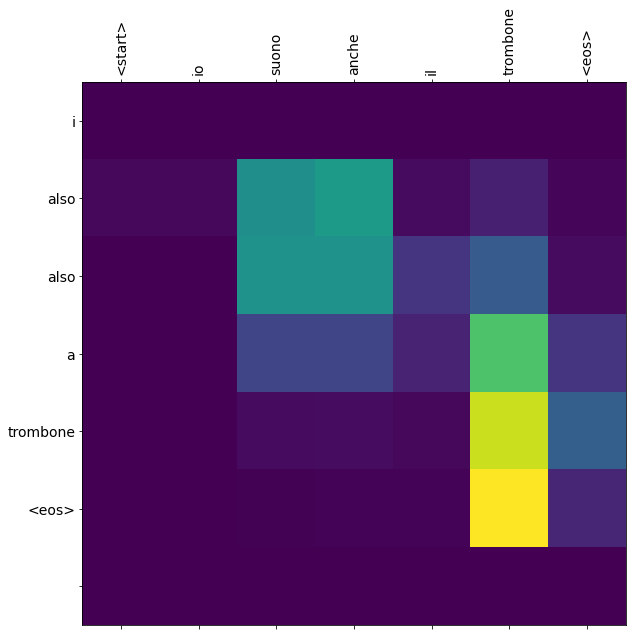

In [ ]:
pred, att = predict(Ita, model)
print()
result = display(Ita, Eng, pred)
print()
plot(att, Ita, result)

In [ ]:
num = 4589
Ita = validation['Italian'][num]
Eng = validation['English'][num]

============================== Inference ==============================
-------------------- started predition --------------------
at time step 0 the word is 0
at time step 0 the word is  [[6]]
at time step 1 the word is  [[19]]
at time step 2 the word is  [[200]]
at time step 3 the word is  [[44]]
at time step 4 the word is  [[10]]
at time step 5 the word is  [[232]]
at time step 6 the word is  [[3]]

Italian:  <start> tom era in ritardo alla festa <eos>
Eng_ref:  tom was late to the party
Predicted:  tom was late at the party <eos> 

BLEU score: 0.5946035575013605



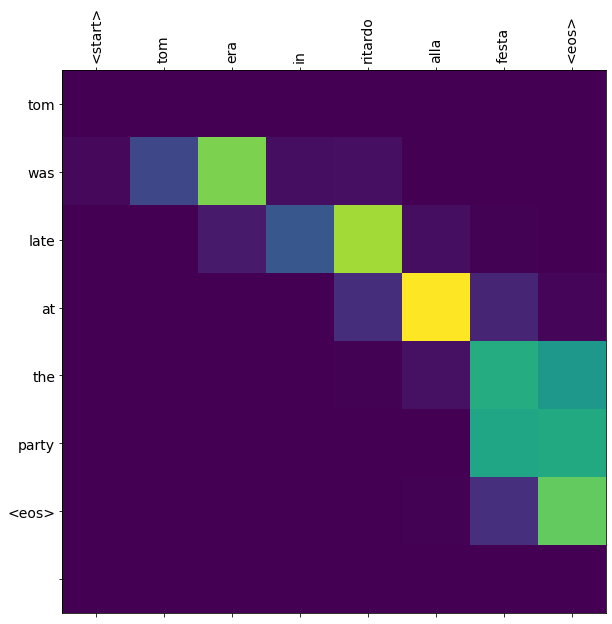

In [ ]:
pred, att = predict(Ita, model)
print()
result = display(Ita, Eng, pred)
print()
plot(att, Ita, result)

In [ ]:
num = 29441
Ita = validation['Italian'][num]
Eng = validation['English'][num]

============================== Inference ==============================
-------------------- started predition --------------------
at time step 0 the word is 0
at time step 0 the word is  [[4]]
at time step 1 the word is  [[1310]]
at time step 2 the word is  [[5]]
at time step 3 the word is  [[41]]
at time step 4 the word is  [[7]]
at time step 5 the word is  [[64]]
at time step 6 the word is  [[3]]

Italian:  <start> vi suggerisco di andare a boston <eos>
Eng_ref:  i suggest you go to boston
Predicted:  i suggest you go to boston <eos> 

BLEU score: 1.0



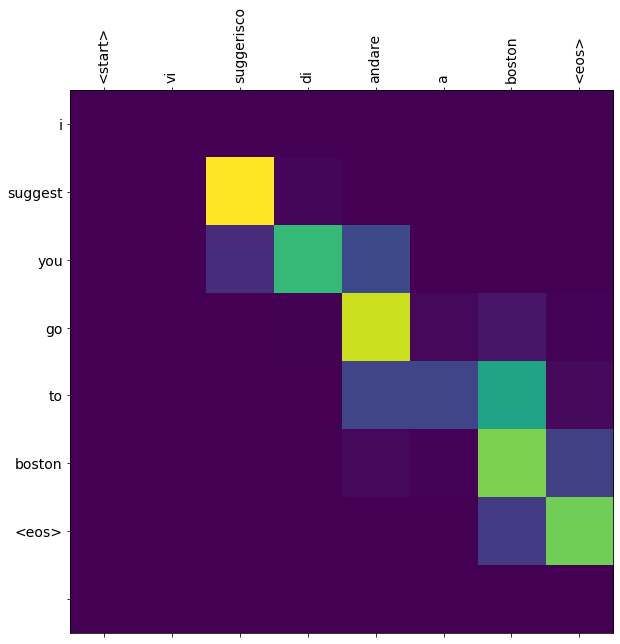

In [ ]:
pred, att = predict(Ita, model)
print()
result = display(Ita, Eng, pred)
print()
plot(att, Ita, result)

In [ ]:
num = 27814
Ita = validation['Italian'][num]
Eng = validation['English'][num]

============================== Inference ==============================
-------------------- started predition --------------------
at time step 0 the word is 0
at time step 0 the word is  [[4]]
at time step 1 the word is  [[19]]
at time step 2 the word is  [[59]]
at time step 3 the word is  [[258]]
at time step 4 the word is  [[53]]
at time step 5 the word is  [[5]]
at time step 6 the word is  [[3]]

Italian:  <start> ero così preoccupato per te <eos>
Eng_ref:  i was so worried about you
Predicted:  i was so worried about you <eos> 

BLEU score: 1.0



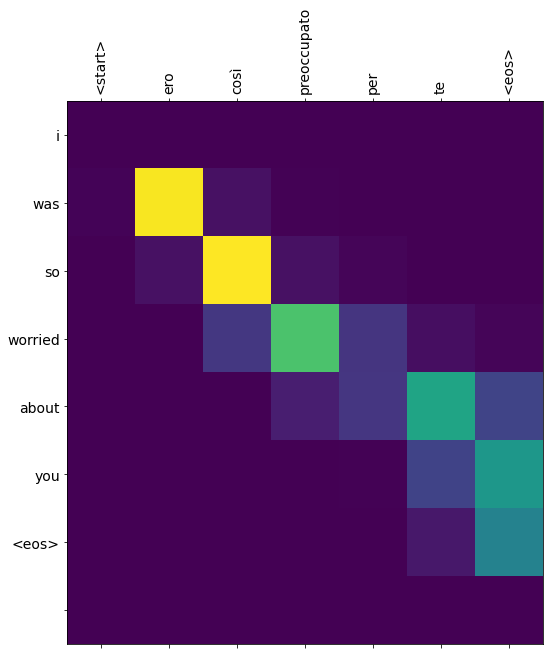

In [ ]:
pred, att = predict(Ita, model)
print()
result = display(Ita, Eng, pred)
print()
plot(att, Ita, result)

In [ ]:
# Calculating average bleu score on 100 val data.
REF = []
PRED = []
BLEU = []
for i in range(1,101):
  Ita = validation['Italian'][i]
  Eng = validation['English'][i]
  test = ita_token.texts_to_sequences([Ita])
  test = pad_sequences([test[0]], maxlen=20, dtype='int32', padding='post')
  test = tf.convert_to_tensor(test)
  initial_state = model.layers[0].initialize_states(1)
  enc_output, enc_state_h, enc_state_c = model.layers[0](test, initial_state)
  state_h, state_c = enc_state_h, enc_state_c
  pred = []
  cur_vec = tf.expand_dims([eng_token.word_index['<start>']], 0)
  for j in range(20):
      infe_output, state_h, state_c, att_weights, _ = model.layers[1].onestepdecoder(cur_vec, enc_output, state_h, state_c)
      att_weights = tf.reshape(att_weights, (-1, ))
      cur_vec1 = np.argmax(infe_output)
      cur_vec = np.reshape(np.argmax(infe_output), (1, 1))
      pred.append(cur_vec1)
      if cur_vec1 == 3:
        break
  result = ''
  for p in pred:
    if p != 0:
      result += eng_token.index_word[p] + ' '
    
  reference = [Eng.split()]
  translation = result.split()
  b = bleu.sentence_bleu(reference, translation[:-1])
  REF.append(Eng)
  PRED.append(result)
  BLEU.append(b)

In [ ]:
OUTPUT = pd.DataFrame(list(zip(REF, PRED, BLEU)), columns = ['Reference', 'Predicited', 'BLEU_Score'])
OUTPUT.head(10)

,Reference,Predicited,BLEU_Score
0,what does tom want to know,what do you want to know tom <eos>,0.467138
1,i felt sick,i felt bad <eos>,0.759836
2,where did you find it,where did you find it <eos>,1.000000
3,tom asked mary to go out to have dinner with him,tom asked mary to take dinner with him <eos>,0.343645
4,tom told me nothing,tom did not tell me anything <eos>,0.759836
5,do you really think that that would work,do you really think that that would work <eos>,1.000000
6,i do not think she would understand it,i do not think you would understand it <eos>,0.500000
7,they do not always obey their parents,they always get them their parents <eos>,0.511508
8,we are not enemies,we are not enemies <eos>,1.000000
9,the soldier gave his name,the soldier made his name <eos>,0.795271


In [ ]:
print("Average bleu score on 100 validation data: {:.4f}".format(np.mean(BLEU)))

Average bleu score on 100 validation data: 0.7623


# General

> Using General function



In [ ]:
tf.keras.backend.clear_session()
model_gen  = Encoder_Decoder(ip_vocab_size = ita_vocab_size, ip_embed_size = 100, 
                 input_len = 20, units = 64, op_vocab_size = eng_vocab_size, op_embed_size = 100, output_len = 20, 
                 score_func = 'general', batch_size = 1024, emb_matrix = embedding_matrix)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
model_gen.compile(optimizer = optimizer, loss= [loss_function])

train_steps = train.shape[0]//1024
valid_steps = validation.shape[0]//1024
model_gen.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=50, validation_data=test_dataloader, validation_steps=valid_steps)
model_gen.summary()

Epoch 1/50
266/266 [==============================] - 116s 436ms/step - loss: 2.0779 - val_loss: 1.8606
Epoch 2/50
266/266 [==============================] - 115s 433ms/step - loss: 1.8610 - val_loss: 1.8474
Epoch 3/50
266/266 [==============================] - 119s 446ms/step - loss: 1.8289 - val_loss: 1.8036
Epoch 4/50
266/266 [==============================] - 115s 432ms/step - loss: 1.7720 - val_loss: 1.7289
Epoch 5/50
266/266 [==============================] - 118s 444ms/step - loss: 1.6854 - val_loss: 1.6341
Epoch 6/50
266/266 [==============================] - 115s 432ms/step - loss: 1.5801 - val_loss: 1.5142
Epoch 7/50
266/266 [==============================] - 119s 448ms/step - loss: 1.4332 - val_loss: 1.3577
Epoch 8/50
266/266 [==============================] - 116s 435ms/step - loss: 1.2860 - val_loss: 1.2247
Epoch 9/50
266/266 [==============================] - 119s 448ms/step - loss: 1.1645 - val_loss: 1.1210
Epoch 10/50
266/266 [==============================] - 116s 436m

Sample Outputs

In [ ]:
num = 23713
Ita = validation['Italian'][num]
Eng = validation['English'][num]

============================== Inference ==============================
-------------------- started predition --------------------
at time step 0 the word is 0
at time step 0 the word is  [[16]]
at time step 1 the word is  [[8]]
at time step 2 the word is  [[1469]]
at time step 3 the word is  [[3]]

Italian:  <start> tutto cambia <eos>
Eng_ref:  everything changes
Predicted:  that is changes <eos> 

BLEU score: 0.7598356856515925



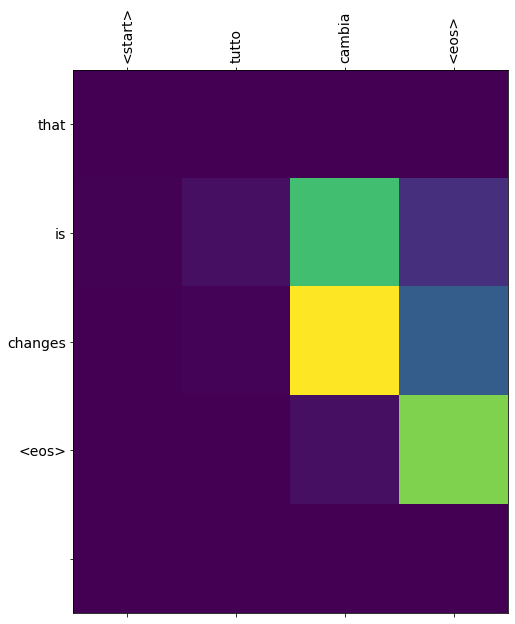

In [ ]:
pred, att = predict(Ita, model_gen)
print()
result = display(Ita, Eng, pred)
print()
plot(att, Ita, result)

In [ ]:
num = 10000
Ita = validation['Italian'][num]
Eng = validation['English'][num]

============================== Inference ==============================
-------------------- started predition --------------------
at time step 0 the word is 0
at time step 0 the word is  [[86]]
at time step 1 the word is  [[73]]
at time step 2 the word is  [[241]]
at time step 3 the word is  [[12]]
at time step 4 the word is  [[171]]
at time step 5 the word is  [[3]]

Italian:  <start> nessuno ha preso peso <eos>
Eng_ref:  nobody gained weight
Predicted:  no one took a little <eos> 

BLEU score: 0



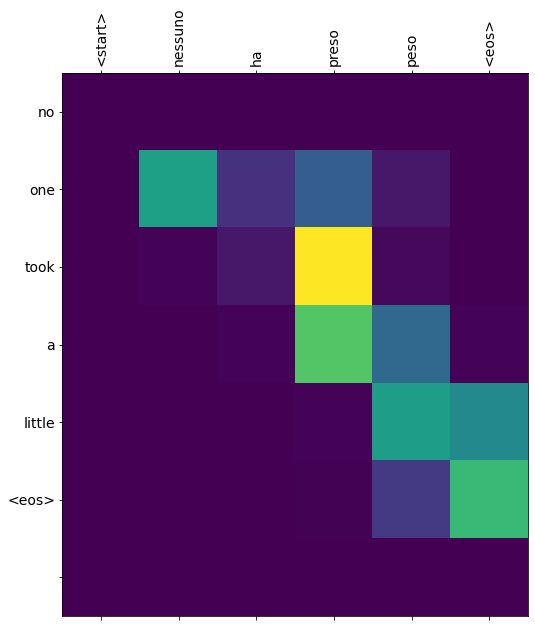

In [ ]:
pred, att = predict(Ita, model_gen)
print()
result = display(Ita, Eng, pred)
print()
plot(att, Ita, result)

In [ ]:
num = 256
Ita = validation['Italian'][num]
Eng = validation['English'][num]

============================== Inference ==============================
-------------------- started predition --------------------
at time step 0 the word is 0
at time step 0 the word is  [[320]]
at time step 1 the word is  [[50]]
at time step 2 the word is  [[244]]
at time step 3 the word is  [[3]]

Italian:  <start> finalmente è capitato <eos>
Eng_ref:  it finally happened
Predicted:  someone has happened <eos> 

BLEU score: 0.7598356856515925



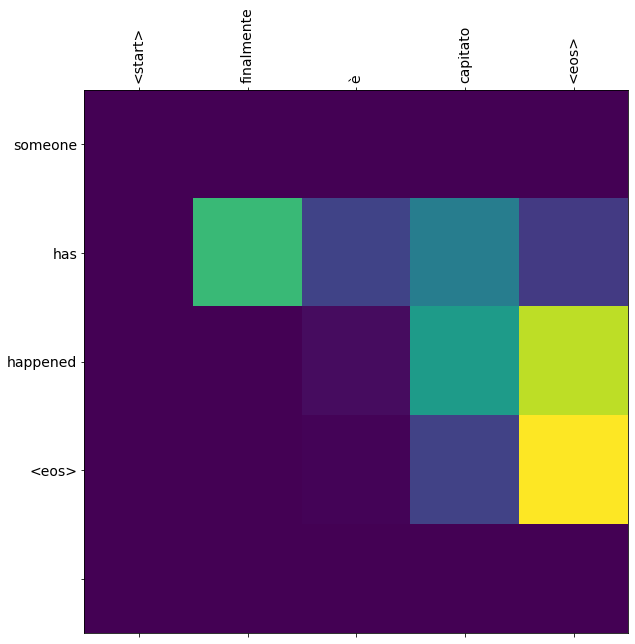

In [ ]:
pred, att = predict(Ita, model_gen)
print()
result = display(Ita, Eng, pred)
print()
plot(att, Ita, result)

In [ ]:
num = 1454
Ita = validation['Italian'][num]
Eng = validation['English'][num]

============================== Inference ==============================
-------------------- started predition --------------------
at time step 0 the word is 0
at time step 0 the word is  [[417]]
at time step 1 the word is  [[6]]
at time step 2 the word is  [[23]]
at time step 3 the word is  [[9]]
at time step 4 the word is  [[325]]
at time step 5 the word is  [[3]]

Italian:  <start> forse tom non vincerà <eos>
Eng_ref:  maybe tom will not win
Predicted:  maybe tom will not win <eos> 

BLEU score: 1.0



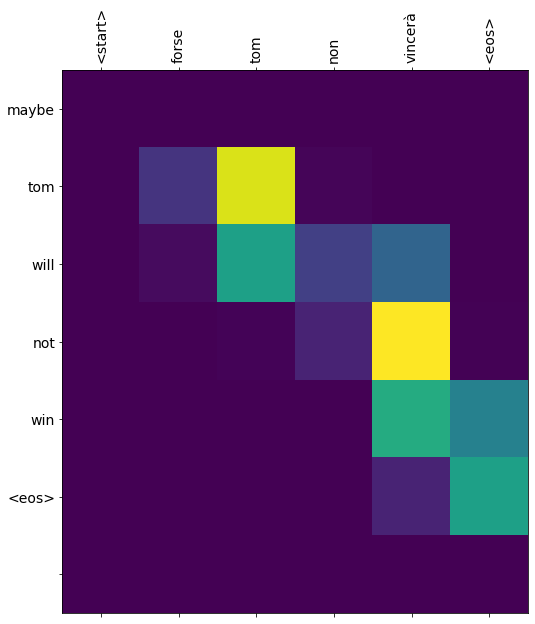

In [ ]:
pred, att = predict(Ita, model_gen)
print()
result = display(Ita, Eng, pred)
print()
plot(att, Ita, result)

In [ ]:
num = 100
Ita = validation['Italian'][num]
Eng = validation['English'][num]

============================== Inference ==============================
-------------------- started predition --------------------
at time step 0 the word is 0
at time step 0 the word is  [[4]]
at time step 1 the word is  [[843]]
at time step 2 the word is  [[843]]
at time step 3 the word is  [[12]]
at time step 4 the word is  [[2175]]
at time step 5 the word is  [[3]]

Italian:  <start> io suono anche il trombone <eos>
Eng_ref:  i also play the trombone
Predicted:  i also also a trombone <eos> 

BLEU score: 0.6223329772884784



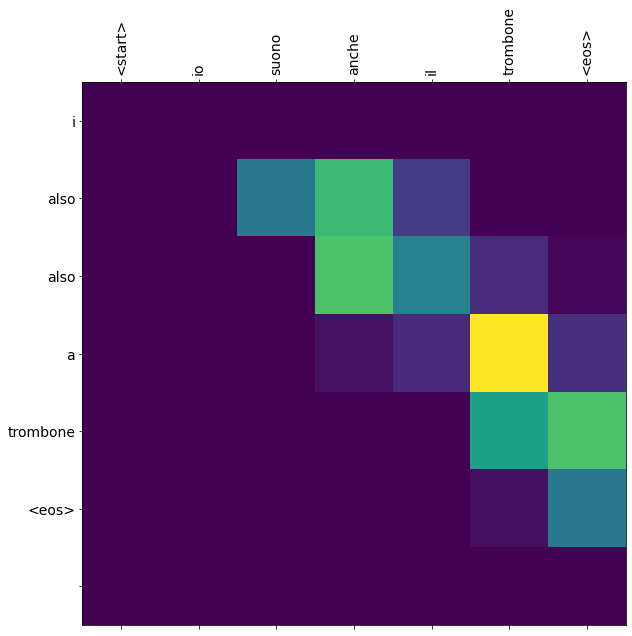

In [ ]:
pred, att = predict(Ita, model_gen)
print()
result = display(Ita, Eng, pred)
print()
plot(att, Ita, result)

In [ ]:
num = 4589
Ita = validation['Italian'][num]
Eng = validation['English'][num]

============================== Inference ==============================
-------------------- started predition --------------------
at time step 0 the word is 0
at time step 0 the word is  [[6]]
at time step 1 the word is  [[19]]
at time step 2 the word is  [[200]]
at time step 3 the word is  [[7]]
at time step 4 the word is  [[10]]
at time step 5 the word is  [[232]]
at time step 6 the word is  [[3]]

Italian:  <start> tom era in ritardo alla festa <eos>
Eng_ref:  tom was late to the party
Predicted:  tom was late to the party <eos> 

BLEU score: 1.0



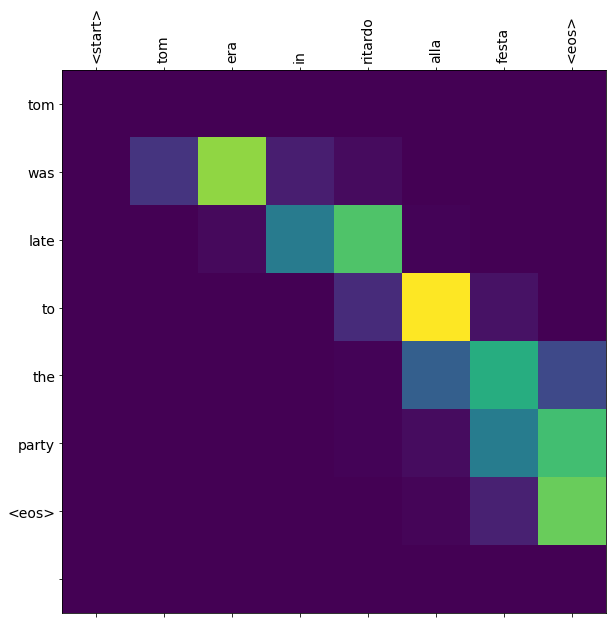

In [ ]:
pred, att = predict(Ita, model_gen)
print()
result = display(Ita, Eng, pred)
print()
plot(att, Ita, result)

In [ ]:
num = 29441
Ita = validation['Italian'][num]
Eng = validation['English'][num]

============================== Inference ==============================
-------------------- started predition --------------------
at time step 0 the word is 0
at time step 0 the word is  [[4]]
at time step 1 the word is  [[1310]]
at time step 2 the word is  [[5]]
at time step 3 the word is  [[41]]
at time step 4 the word is  [[7]]
at time step 5 the word is  [[64]]
at time step 6 the word is  [[3]]

Italian:  <start> vi suggerisco di andare a boston <eos>
Eng_ref:  i suggest you go to boston
Predicted:  i suggest you go to boston <eos> 

BLEU score: 1.0



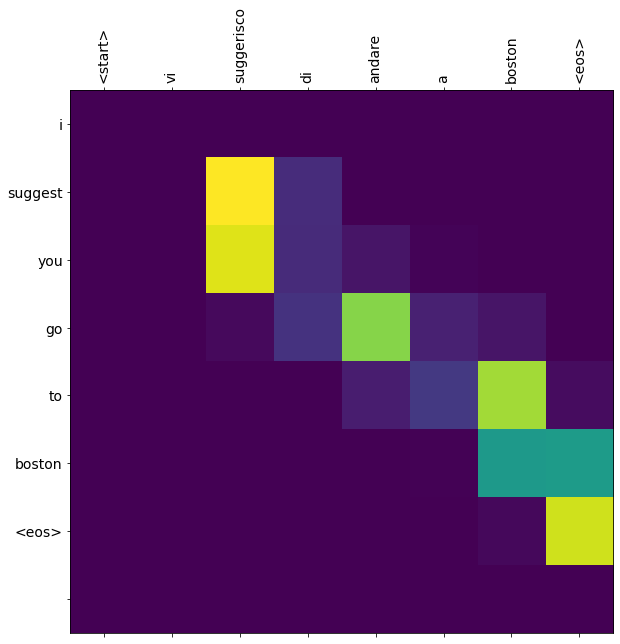

In [ ]:
pred, att = predict(Ita, model_gen)
print()
result = display(Ita, Eng, pred)
print()
plot(att, Ita, result)

In [ ]:
num = 27814
Ita = validation['Italian'][num]
Eng = validation['English'][num]

============================== Inference ==============================
-------------------- started predition --------------------
at time step 0 the word is 0
at time step 0 the word is  [[4]]
at time step 1 the word is  [[19]]
at time step 2 the word is  [[59]]
at time step 3 the word is  [[258]]
at time step 4 the word is  [[53]]
at time step 5 the word is  [[5]]
at time step 6 the word is  [[3]]

Italian:  <start> ero così preoccupato per te <eos>
Eng_ref:  i was so worried about you
Predicted:  i was so worried about you <eos> 

BLEU score: 1.0



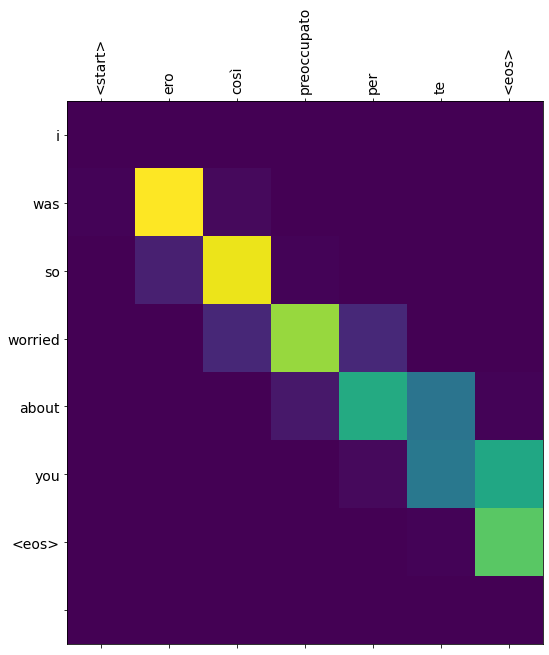

In [ ]:
pred, att = predict(Ita, model_gen)
print()
result = display(Ita, Eng, pred)
print()
plot(att, Ita, result)

In [ ]:
# Calculating average bleu scores on 100 val data.
REF = []
PRED = []
BLEU = []
for i in range(1,101):
  Ita = validation['Italian'][i]
  Eng = validation['English'][i]
  test = ita_token.texts_to_sequences([Ita])
  test = pad_sequences([test[0]], maxlen=20, dtype='int32', padding='post')
  test = tf.convert_to_tensor(test)
  initial_state = model_gen.layers[0].initialize_states(1)
  enc_output, enc_state_h, enc_state_c = model_gen.layers[0](test, initial_state)
  state_h, state_c = enc_state_h, enc_state_c
  pred = []
  cur_vec = tf.expand_dims([eng_token.word_index['<start>']], 0)
  for j in range(20):
      infe_output, state_h, state_c, att_weights, _ = model_gen.layers[1].onestepdecoder(cur_vec, enc_output, state_h, state_c)
      att_weights = tf.reshape(att_weights, (-1, ))
      cur_vec1 = np.argmax(infe_output)
      cur_vec = np.reshape(np.argmax(infe_output), (1, 1))
      pred.append(cur_vec1)
      if cur_vec1 == 3:
        break
  result = ''
  for p in pred:
    if p != 0:
      result += eng_token.index_word[p] + ' '
    
  reference = [Eng.split()]
  translation = result.split()
  b = bleu.sentence_bleu(reference, translation[:-1])
  REF.append(Eng)
  PRED.append(result)
  BLEU.append(b)

In [ ]:
OUTPUT = pd.DataFrame(list(zip(REF, PRED, BLEU)), columns = ['Reference', 'Predicited', 'BLEU_Score'])
OUTPUT.head(10)

,Reference,Predicited,BLEU_Score
0,what does tom want to know,what do you want to know tom <eos>,0.467138
1,i felt sick,i felt bad <eos>,0.759836
2,where did you find it,where did you find it <eos>,1.000000
3,tom asked mary to go out to have dinner with him,tom asked mary go out dinner with him <eos>,0.480095
4,tom told me nothing,tom did not tell me anything <eos>,0.759836
5,do you really think that that would work,do you really think that that would work <eos>,1.000000
6,i do not think she would understand it,i do not think she would understand it <eos>,1.000000
7,they do not always obey their parents,they not always obey their parents <eos>,0.673182
8,we are not enemies,we are not enemies <eos>,1.000000
9,the soldier gave his name,the soldier has his name <eos>,0.795271


In [ ]:
print("Average bleu score on 100 validation data: {:.4f}".format(np.mean(BLEU)))

Average bleu score on 100 validation data: 0.7678


# Summary



> 100 dim embedding is used in Encoder embeddding layer and pre-trained embeddings are used for Decoder embedding layer.

> 64 LSTM units are used.





| model | Avg.BLEU score |
| ------| ---------------| 
|Simple Encoder-Decoder |0.6605|
|Encoder-Decoder (Attention -Concat) |0.7623|
|Encoder-Decoder (Attention -General) |0.7678|